In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import preprocessing
from sklearn.utils import resample

In [2]:
train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [5]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int64
id_01            144233 non-null float64
id_02            140872 non-null float64
id_03            66324 non-null float64
id_04            66324 non-null float64
id_05            136865 non-null float64
id_06            136865 non-null float64
id_07            5155 non-null float64
id_08            5155 non-null float64
id_09            74926 non-null float64
id_10            74926 non-null float64
id_11            140978 non-null float64
id_12            144233 non-null object
id_13            127320 non-null float64
id_14            80044 non-null float64
id_15            140985 non-null object
id_16            129340 non-null object
id_17            139369 non-null float64
id_18            45113 non-null float64
id_19            139318 non-null float64
id_20            139261 non-null float64
id_21            5159 non-null float64
id_2

Text(0.5,1,'Target')

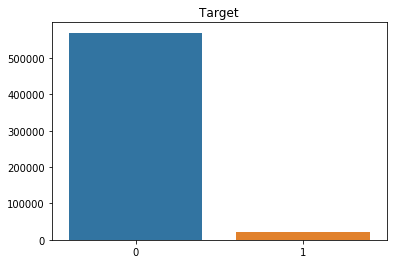

In [6]:
x = train_transaction['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target')

Как видно класс очень несбалансирован. Придется использовать андер- или оверсемплинг. Для начала склеим датафреймы и создадим выборки. 

In [7]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
print(train.shape)
print(test.shape)
y_train = train['isFraud'].copy()

(590540, 435)
(506691, 434)


In [8]:
# удаляем target, заполняем NaN
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

Преобразуем данны из столбца со временем в часы суток. 

In [9]:
def make_hour_feature(df, tname='TransactionDT'):
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

In [10]:
X_train['hours'] = make_hour_feature(X_train)

In [11]:
X_test['hours'] = make_hour_feature(X_test)

In [12]:
for x in X_test['hours']:
        if x>4.0 and x<11.0:
            X_test['Fraud_hours'] = 100
        else:
            X_test['Fraud_hours'] = -100

In [13]:
for x in X_train['hours']:
        if x>4.0 and x<11.0:
            X_train['Fraud_hours'] = 100
        else:
            X_train['Fraud_hours'] = -100

In [14]:
X_train['Fraud_hours']

0        -100
1        -100
2        -100
3        -100
4        -100
5        -100
6        -100
7        -100
8        -100
9        -100
10       -100
11       -100
12       -100
13       -100
14       -100
15       -100
16       -100
17       -100
18       -100
19       -100
20       -100
21       -100
22       -100
23       -100
24       -100
25       -100
26       -100
27       -100
28       -100
29       -100
         ... 
590510   -100
590511   -100
590512   -100
590513   -100
590514   -100
590515   -100
590516   -100
590517   -100
590518   -100
590519   -100
590520   -100
590521   -100
590522   -100
590523   -100
590524   -100
590525   -100
590526   -100
590527   -100
590528   -100
590529   -100
590530   -100
590531   -100
590532   -100
590533   -100
590534   -100
590535   -100
590536   -100
590537   -100
590538   -100
590539   -100
Name: Fraud_hours, Length: 590540, dtype: int64

In [15]:
del train, test, train_transaction, train_identity, test_transaction, test_identity

Выделим категориальные признаки и применим label encoding.

In [16]:

for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   


ДФ занимает слишком много памяти, необходимо преобразование. 

In [17]:
%%time
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 30 µs


In [18]:
%%time
X_train = reduce_mem_usage2(X_train)
X_test = reduce_mem_usage2(X_test)

Memory usage of dataframe is 1964.38 MB
Memory usage after optimization is: 528.83 MB
Decreased by 73.1%
Memory usage of dataframe is 1685.47 MB
Memory usage after optimization is: 461.47 MB
Decreased by 72.6%
CPU times: user 5min 14s, sys: 4min 59s, total: 10min 13s
Wall time: 5min 16s


Следующие два блока результата не принесли, но пусть будут тут, потому что я над ними страдал. 

In [ ]:
#Scale_pos_weight
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
train_labels = dtrain.get_label()
ratio= float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)

In [19]:
X = pd.concat([X_train,y_train],axis=1)
not_fraud = X[X.isFraud==0]
fraud = X[X.isFraud==1]


Андерсемплинг работает лучше всего. 

In [20]:
downsampled_not_fraud = resample(not_fraud, replace = False, # без замены,
                       n_samples = len(fraud), # кол-во не фрода
                        random_state = 27) 

# складываем не фроды и фроды
downsampled = pd.concat([downsampled_not_fraud, fraud])

# проверяем результат
downsampled.isFraud.value_counts()

1    20663
0    20663
Name: isFraud, dtype: int64

Text(0,0.5,'количество')

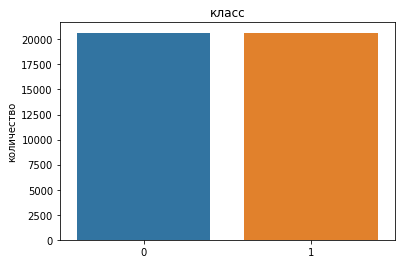

In [21]:
y=downsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('класс')
plt.ylabel('количество')

In [22]:
# удаляем таргет
X_train = downsampled.drop('isFraud', axis=1)

Провели андерсемплинг, чтобы не работать с огромным массивом данных. 
Теперь необходимо преобразовать категориальные признаки. Для этого будем использовать label encoding, так как данных слишком много. 

In [23]:
y_train = downsampled.isFraud

In [30]:
clf = xgb.XGBClassifier(n_estimators=400, 
                        n_jobs=4,
                        max_depth=11,
                        learning_rate=0.015, num_leaves = 220,
                        subsample=0.7,
                        colsample_bytree=0.75,
                        missing=-999, reg_lambda = 0.3)

In [50]:
clf = xgb.XGBClassifier(n_estimators=400, 
                        n_jobs=4,
                        max_depth=11,
                        learning_rate=0.25, num_leaves = 220,
                        subsample=1.0,
                        colsample_bytree=1.0,
                        missing=-999)

In [51]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1.0, gamma=0,
       learning_rate=0.25, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=-999, n_estimators=400, n_jobs=4,
       nthread=None, num_leaves=220, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1.0, verbosity=1)

In [52]:
sample_submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('grid.csv')

Все что ниже это черновики экспериментов над параметрами. 

In [47]:
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import *

xgb_model = xgb.XGBClassifier()
parameters = {'nthread':[5, 10], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.25, 0.5], #so called `eta` value
              'max_depth': [11],
              'min_child_weight': [5, 11],
              'silent': [0],
              'subsample': [0.5, 1.0],
              'colsample_bytree': [0.5, 1.0],
              'n_estimators': [410], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}
clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(y_train, n_folds=4, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)
clf.fit(X_train, y_train)
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

sample_submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('NEW.csv')

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 
[CV

[CV]  colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -13.9min
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -10.6min
[CV] colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -10.6min
[CV] colsample_bytree=0.5, lear

[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 79.3min


[CV]  colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -11.5min
[CV] colsample_bytree=0.5, learning_rate=0.25, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 
[CV]  colsample_bytree=0.5, learning_rate=0.05, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -11.6min
[CV] colsample_bytree=0.5, learning_rate=0.25, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 
[CV]  colsample_bytree=0.5, learning_rate=0.25, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 -10.3min
[CV] colsample_bytree=0.5, learnin

[CV] colsample_bytree=0.5, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -10.6min
[CV] colsample_bytree=0.5, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -10.4min
[CV] colsample_bytree=0.5, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_ra

[CV]  colsample_bytree=0.5, learning_rate=0.5, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 -10.4min
[CV] colsample_bytree=0.5, learning_rate=0.5, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 
[CV]  colsample_bytree=0.5, learning_rate=0.5, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 -10.4min
[CV] colsample_bytree=0.5, learning_rate=0.5, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.5, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -10.5min
[CV] colsample_bytree=0.5, learning_ra

[CV] colsample_bytree=1.0, learning_rate=0.05, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 
[CV]  colsample_bytree=1.0, learning_rate=0.05, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 -18.8min
[CV] colsample_bytree=1.0, learning_rate=0.05, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 
[CV]  colsample_bytree=1.0, learning_rate=0.05, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 -18.8min
[CV] colsample_bytree=1.0, learning_rate=0.05, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 
[CV]  colsample_bytree=1.0, learning_rate=0.05,

[CV]  colsample_bytree=1.0, learning_rate=0.05, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -19.8min
[CV] colsample_bytree=1.0, learning_rate=0.05, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=1.0, learning_rate=0.05, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -19.7min
[CV] colsample_bytree=1.0, learning_rate=0.05, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=1.0, learning_rate=0.05, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -20.0min
[CV] colsample_bytree=1.0, lear

[CV] colsample_bytree=1.0, learning_rate=0.25, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 
[CV]  colsample_bytree=1.0, learning_rate=0.25, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 -18.3min
[CV] colsample_bytree=1.0, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=1.0, learning_rate=0.25, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -19.1min
[CV] colsample_bytree=1.0, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=1.0, learning_rate=

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 432.0min


[CV] colsample_bytree=1.0, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 
[CV]  colsample_bytree=1.0, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -24.8min
[CV] colsample_bytree=1.0, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 
[CV]  colsample_bytree=1.0, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 -20.2min
[CV] colsample_bytree=1.0, learning_rate=0.25, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 
[CV]  colsample_bytree=1.0, learning_r

[CV]  colsample_bytree=1.0, learning_rate=0.5, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -18.9min
[CV] colsample_bytree=1.0, learning_rate=0.5, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=1.0, learning_rate=0.5, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -18.7min
[CV] colsample_bytree=1.0, learning_rate=0.5, max_depth=11, min_child_weight=11, missing=-999, n_estimators=410, nthread=5, objective=binary:logistic, seed=1337, silent=0, subsample=0.5 
[CV]  colsample_bytree=1.0, learning_rate=0.5, max_depth=11, min_child_weight=5, missing=-999, n_estimators=410, nthread=10, objective=binary:logistic, seed=1337, silent=0, subsample=1.0 -17.7min
[CV] colsample_bytree=1.0, learning_ra

[Parallel(n_jobs=5)]: Done 192 out of 192 | elapsed: 589.8min finished


Raw AUC score: 0.9522944310463629
colsample_bytree: 1.0
learning_rate: 0.25
max_depth: 11
min_child_weight: 5
missing: -999
n_estimators: 410
nthread: 5
objective: 'binary:logistic'
seed: 1337
silent: 0
subsample: 1.0


In [ ]:
from sklearn import cross_validation


n_trees = list(range(10,500,50))
xgb_scoring = []
for n_tree in n_trees:
    clf = xgb.XGBClassifier(n_estimators=n_tree,
                        n_jobs=4,
                        max_depth=5, min_child_weight = 1, gamma = 0.1,
                        learning_rate=0.05,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        missing=-999)


    score = cross_validation.cross_val_score(clf, X_train, y_train, 
                                             scoring = 'accuracy', cv = 3)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

In [ ]:
import pylab
pylab.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

In [ ]:
childs = list(range(1,6,1))
xgb_scoring = []
for ch in childs:
    clf = xgb.XGBClassifier(n_estimators=410,
                        n_jobs=4,
                        max_depth=5, min_child_weight = ch, gamma = 0.1,
                        learning_rate=0.05,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        missing=-999)


    score = cross_validation.cross_val_score(clf, X_train, y_train, 
                                             scoring = 'accuracy', cv = 3)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

In [ ]:
pylab.plot(range(1,6,1), xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

In [ ]:
dpth = list(range(1,10,1))
xgb_scoring = []
for d in dpth:
    clf = xgb.XGBClassifier(n_estimators=410,
                        n_jobs=4,
                        max_depth=d, min_child_weight = 2, gamma = 0.1,
                        learning_rate=0.05,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        missing=-999)


    score = cross_validation.cross_val_score(clf, X_train, y_train, 
                                             scoring = 'accuracy', cv = 3)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

In [ ]:
pylab.plot(range(1,10,1), xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')